# Fine-tuning - Velocity prediction

We will use the pre-trained StorSeismic model to perform a velocity estimation task. The input and output of the network are adjusted to clean seismic data and their corresponding velocity profile, respectively.

## Load required modules

In [1]:
from transformers import BertConfig, BertForMaskedLM
import transformers
import torch.nn.functional as F
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from tqdm import tqdm
import os
import time
from radam import RAdam
import sys
import pandas as pd
import itertools

from storseismic.modules import *
from storseismic.train import run_velpred
from storseismic.utils import *

pd.set_option('display.max_rows', None)
torch.cuda.empty_cache()

params = {
    'savefig.dpi': 600,  # to adjust notebook inline plot size
    'figure.dpi' : 600,
    'axes.labelsize':14,  # fontsize for x and y labels (was 10)
    'axes.titlesize':14,
    'axes.titleweight': 'bold',
    'legend.fontsize': 14,  # was 10
    'xtick.labelsize':12,
    'ytick.labelsize':12,
    'font.family': 'serif',
}
matplotlib.rcParams.update(params)

## Initialization

### Fine-tuning configuration

In [2]:
config_path = "./results/pretrain/"
config = torch.load(os.path.join(config_path, 'config.pt'))

# Model Parameter
config.vel_size = 271

# Training Parameter
config.batch_size = 16
config.loss_fn = "l2" # "l2", "ssim", "ssiml1"
config.optim = "radam" # "adam", "radam"
config.lr = 5e-4
config.epoch = 1000
config.warmup = "none" if config.pre_ln else 0
config.patience = 20

# I/O parameter
config.parent_dir = './results/finetune/velpred/'
config.model_path = './results/pretrain/'
config.dataset = './data/finetune/'

config

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "batch_size": 16,
  "classifier_dropout": null,
  "dataset": "./data/finetune/",
  "embedding_type": "none",
  "epoch": 1000,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 256,
  "initializer_range": 0.02,
  "input_type": "trace",
  "intermediate_size": 1024,
  "layer_norm_eps": 1e-12,
  "loss_fn": "l2",
  "lr": 0.0005,
  "max_position_embeddings": 20,
  "model_path": "./results/pretrain/",
  "model_type": "bert",
  "num_attention_heads": 4,
  "num_hidden_ffn": 4,
  "num_hidden_layers": 4,
  "optim": "radam",
  "output_attentions": true,
  "output_hidden_states": true,
  "output_scores": true,
  "pad_token_id": 0,
  "parent_dir": "./results/finetune/velpred/",
  "patience": 20,
  "position_embedding_type": "sincos",
  "pre_ln": true,
  "transformers_version": "4.20.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vel_size": 271,
  "vocab_size": 271,
  "warmup": "none"
}

### Load data and wrap in Pytorch DataLoader

In [3]:
train_data = torch.load(os.path.join(config.dataset, 'train_data.pt'))
test_data = torch.load(os.path.join(config.dataset, 'test_data.pt'))

vmin_all = -1
vmax_all = 1

config.vel_min = torch.min(train_data.encodings['vel'])
config.vel_max = torch.max(train_data.encodings['vel'])

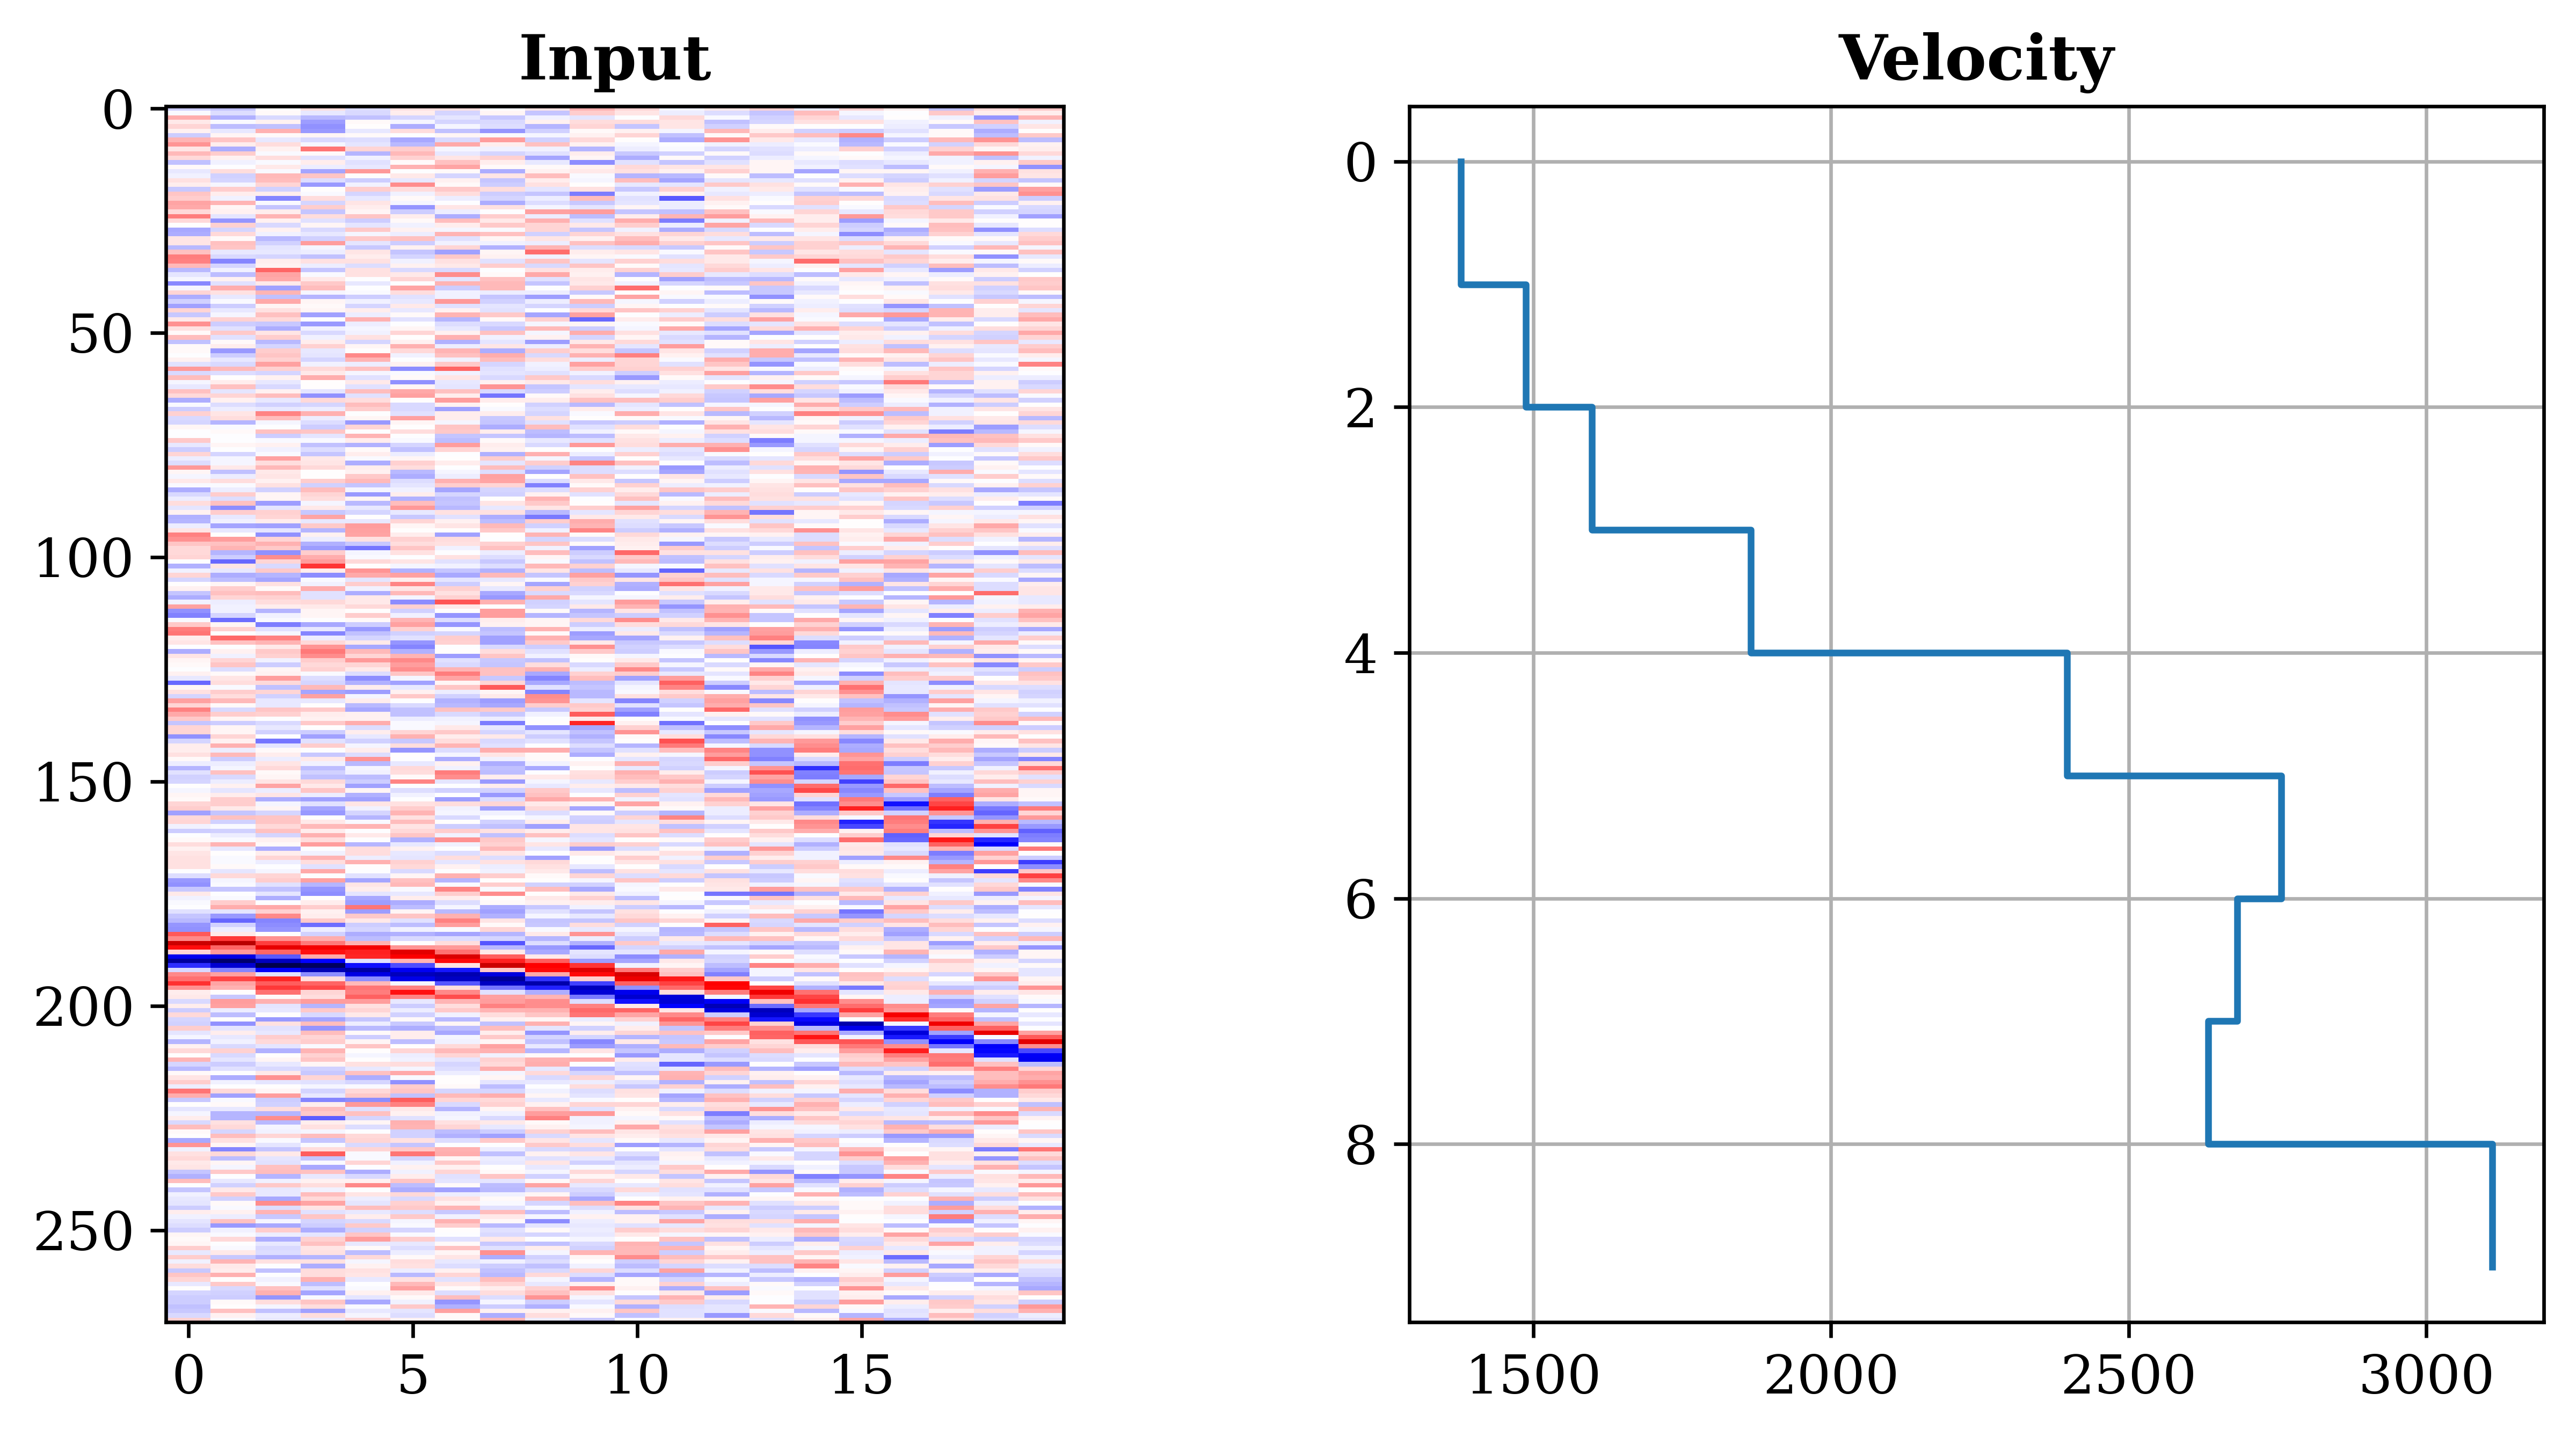

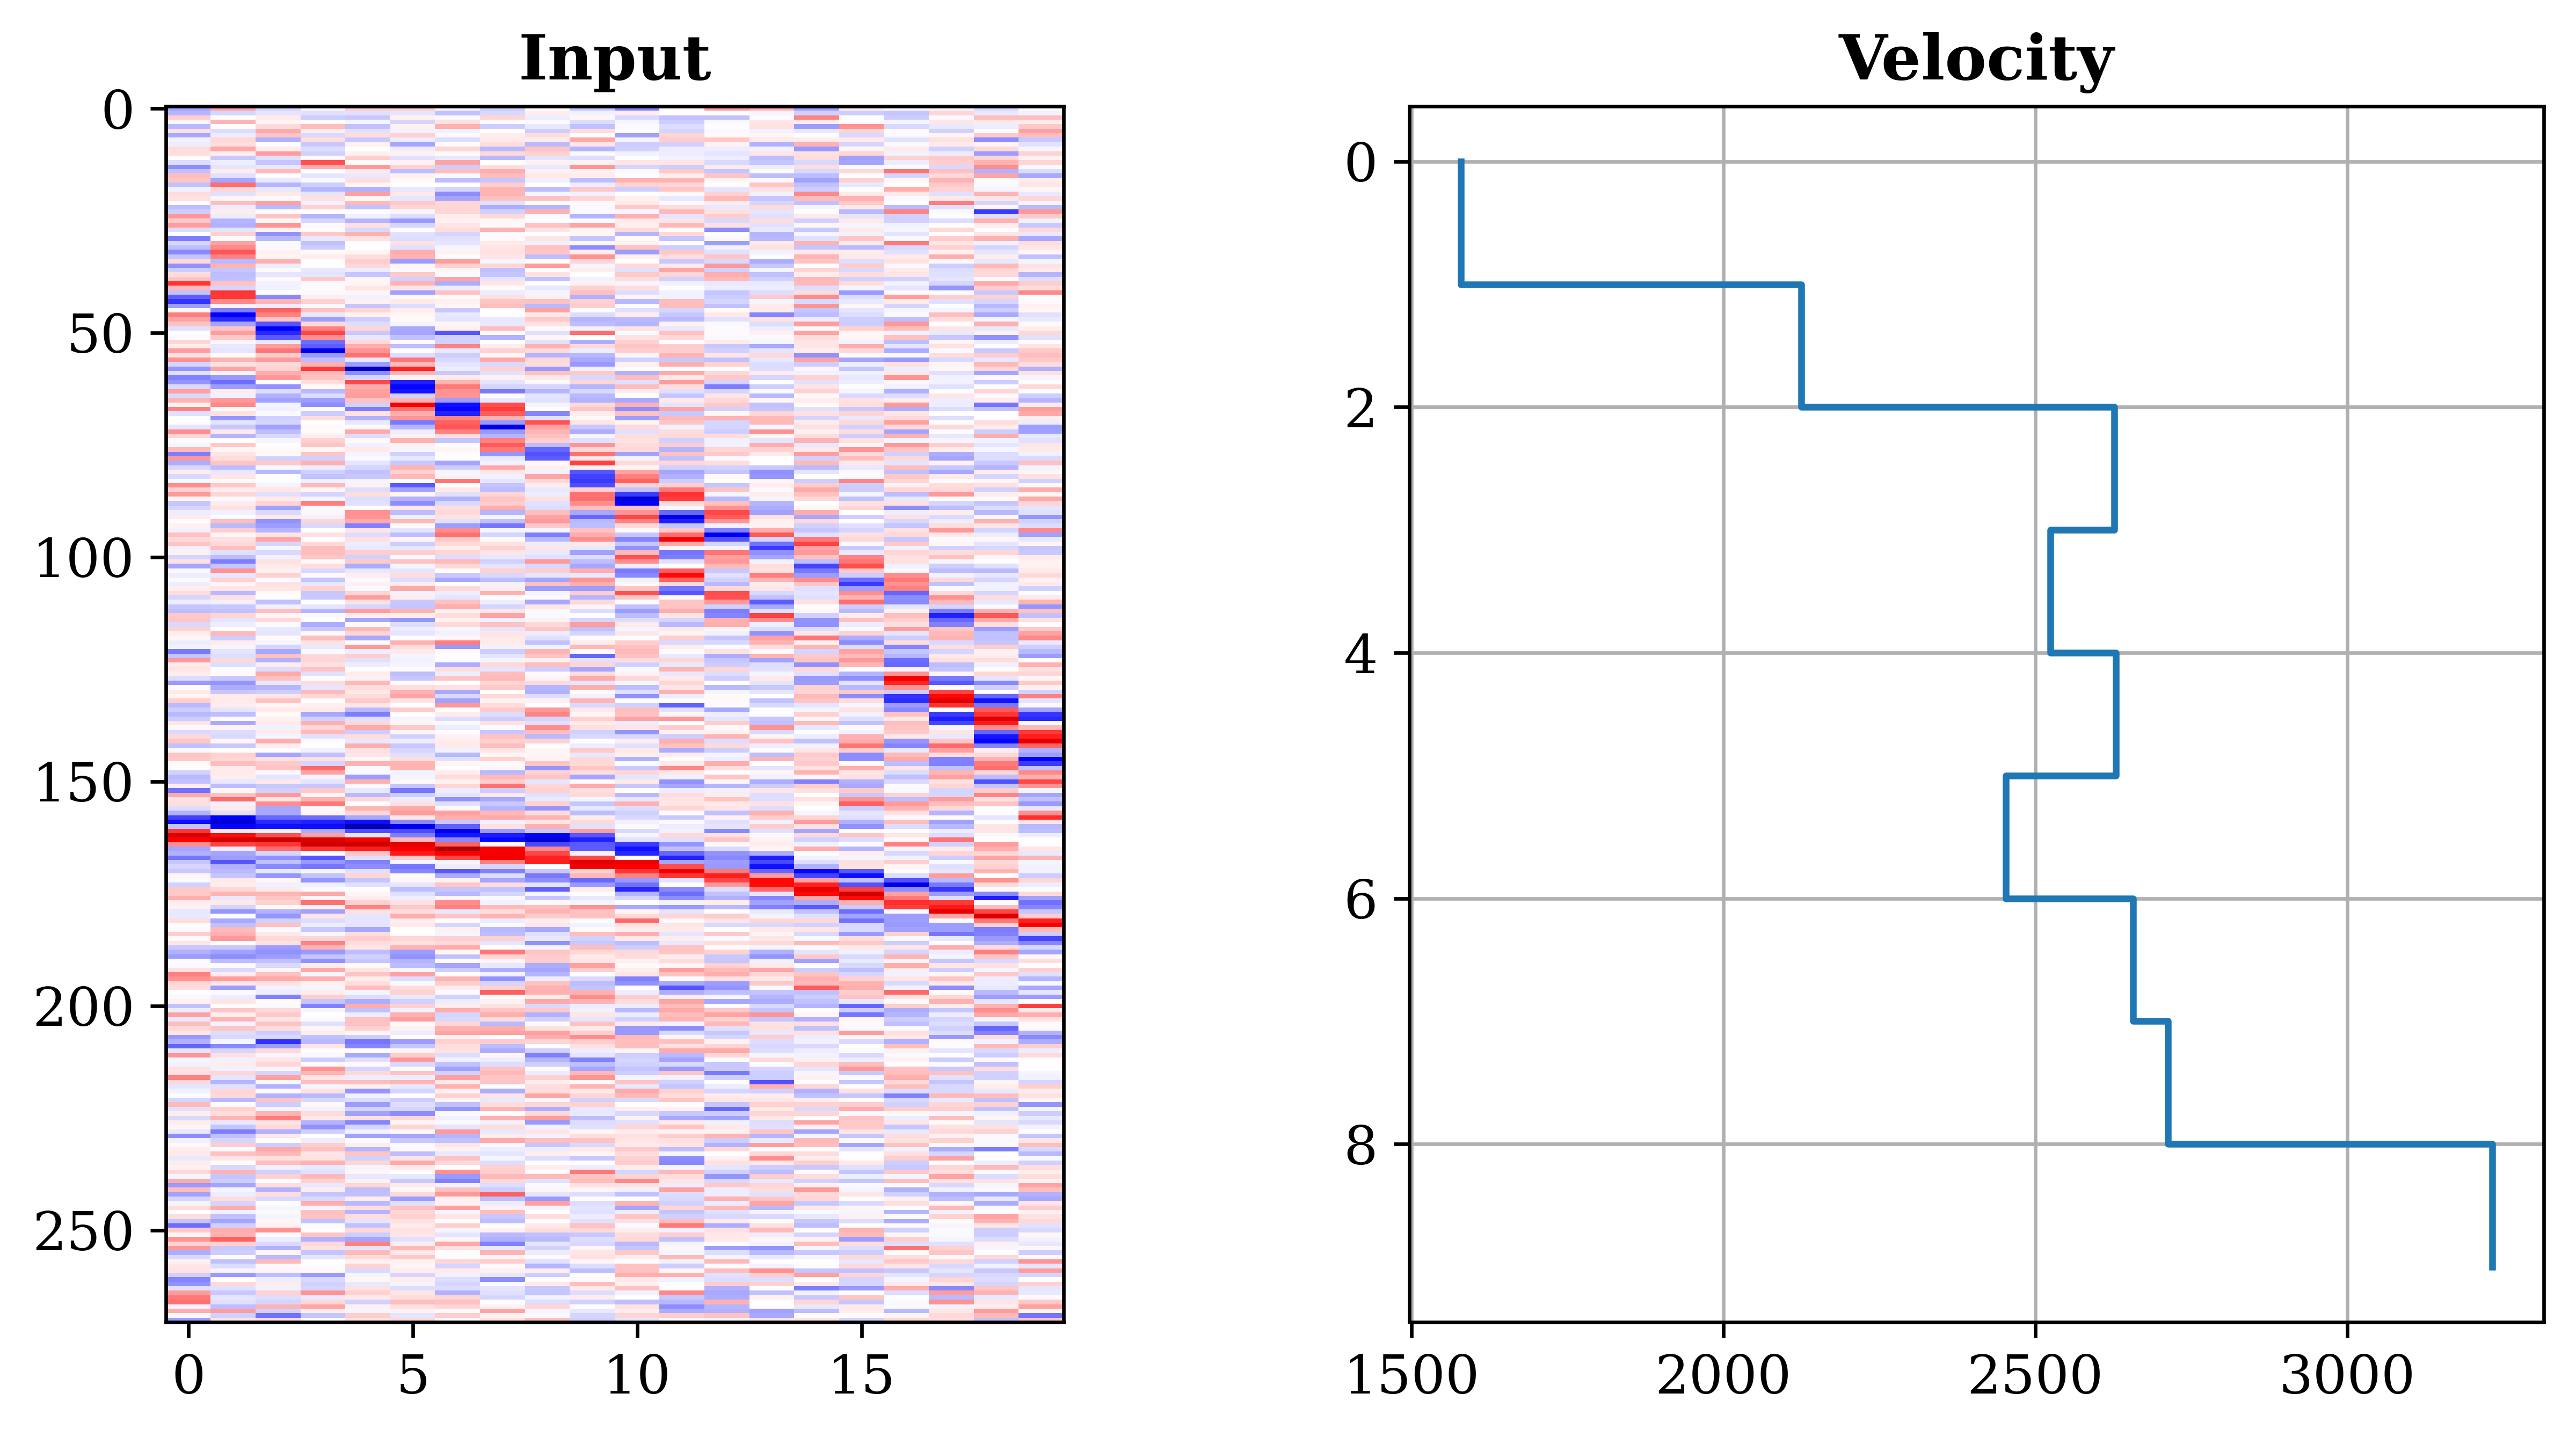

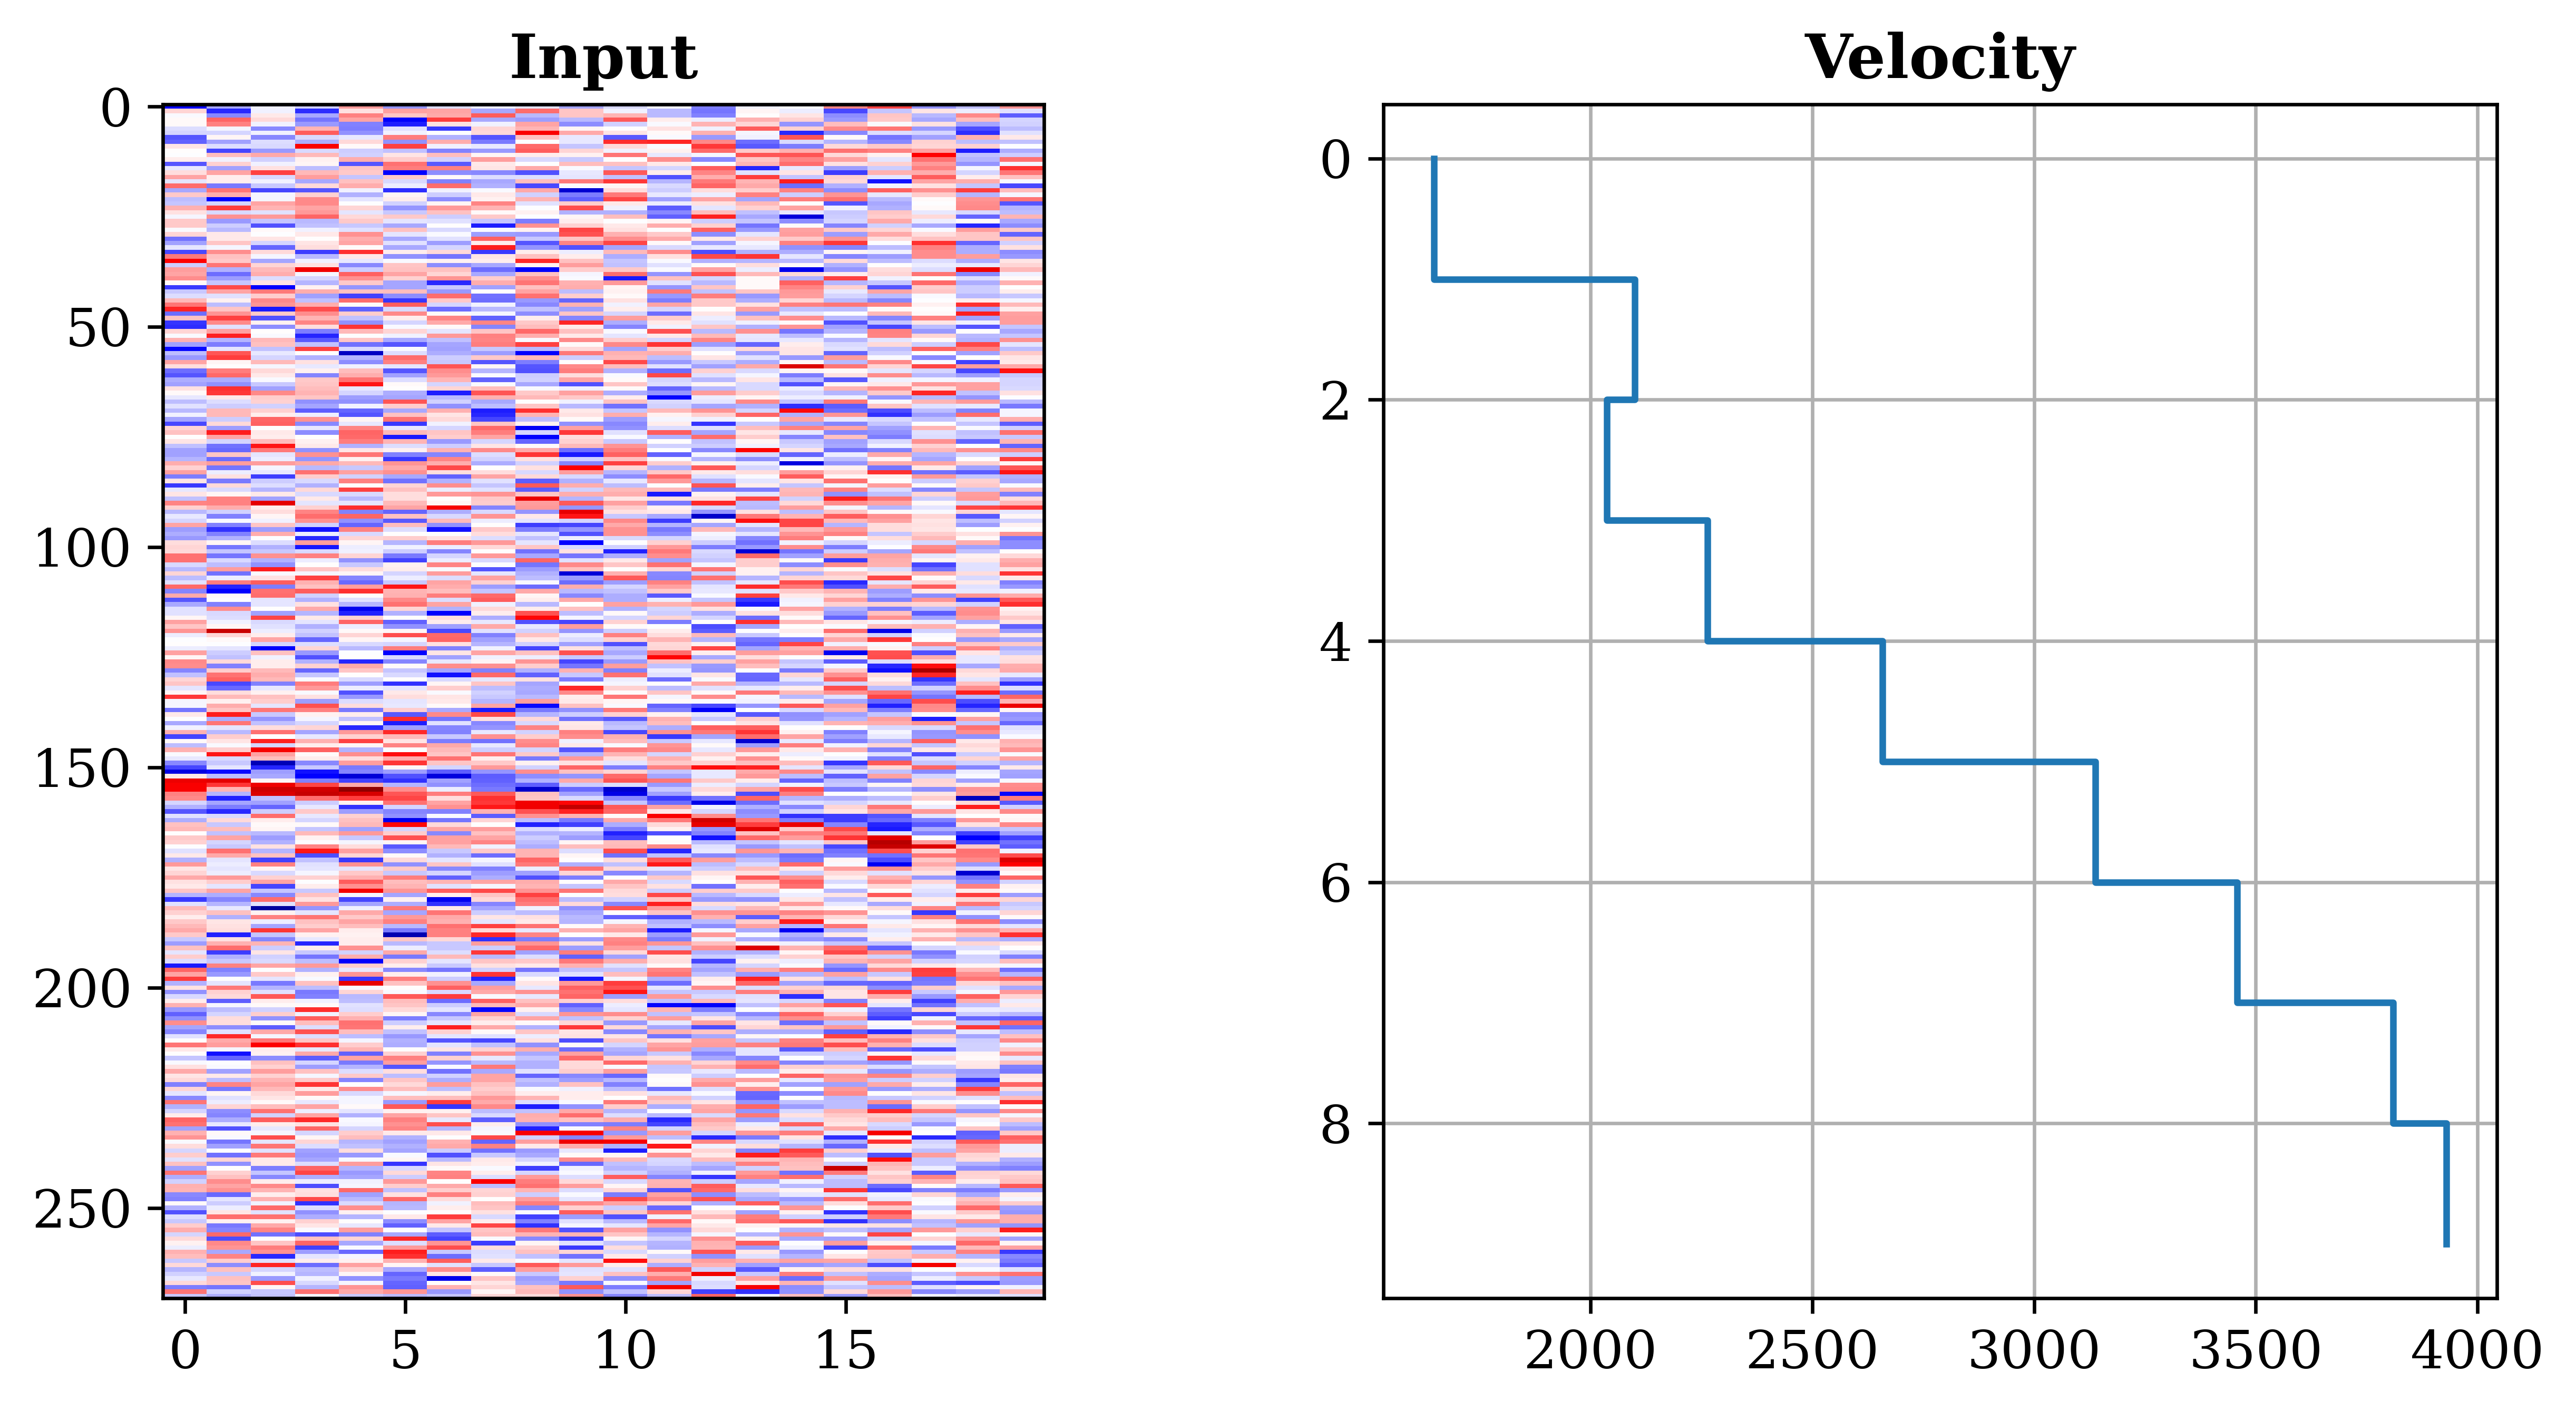

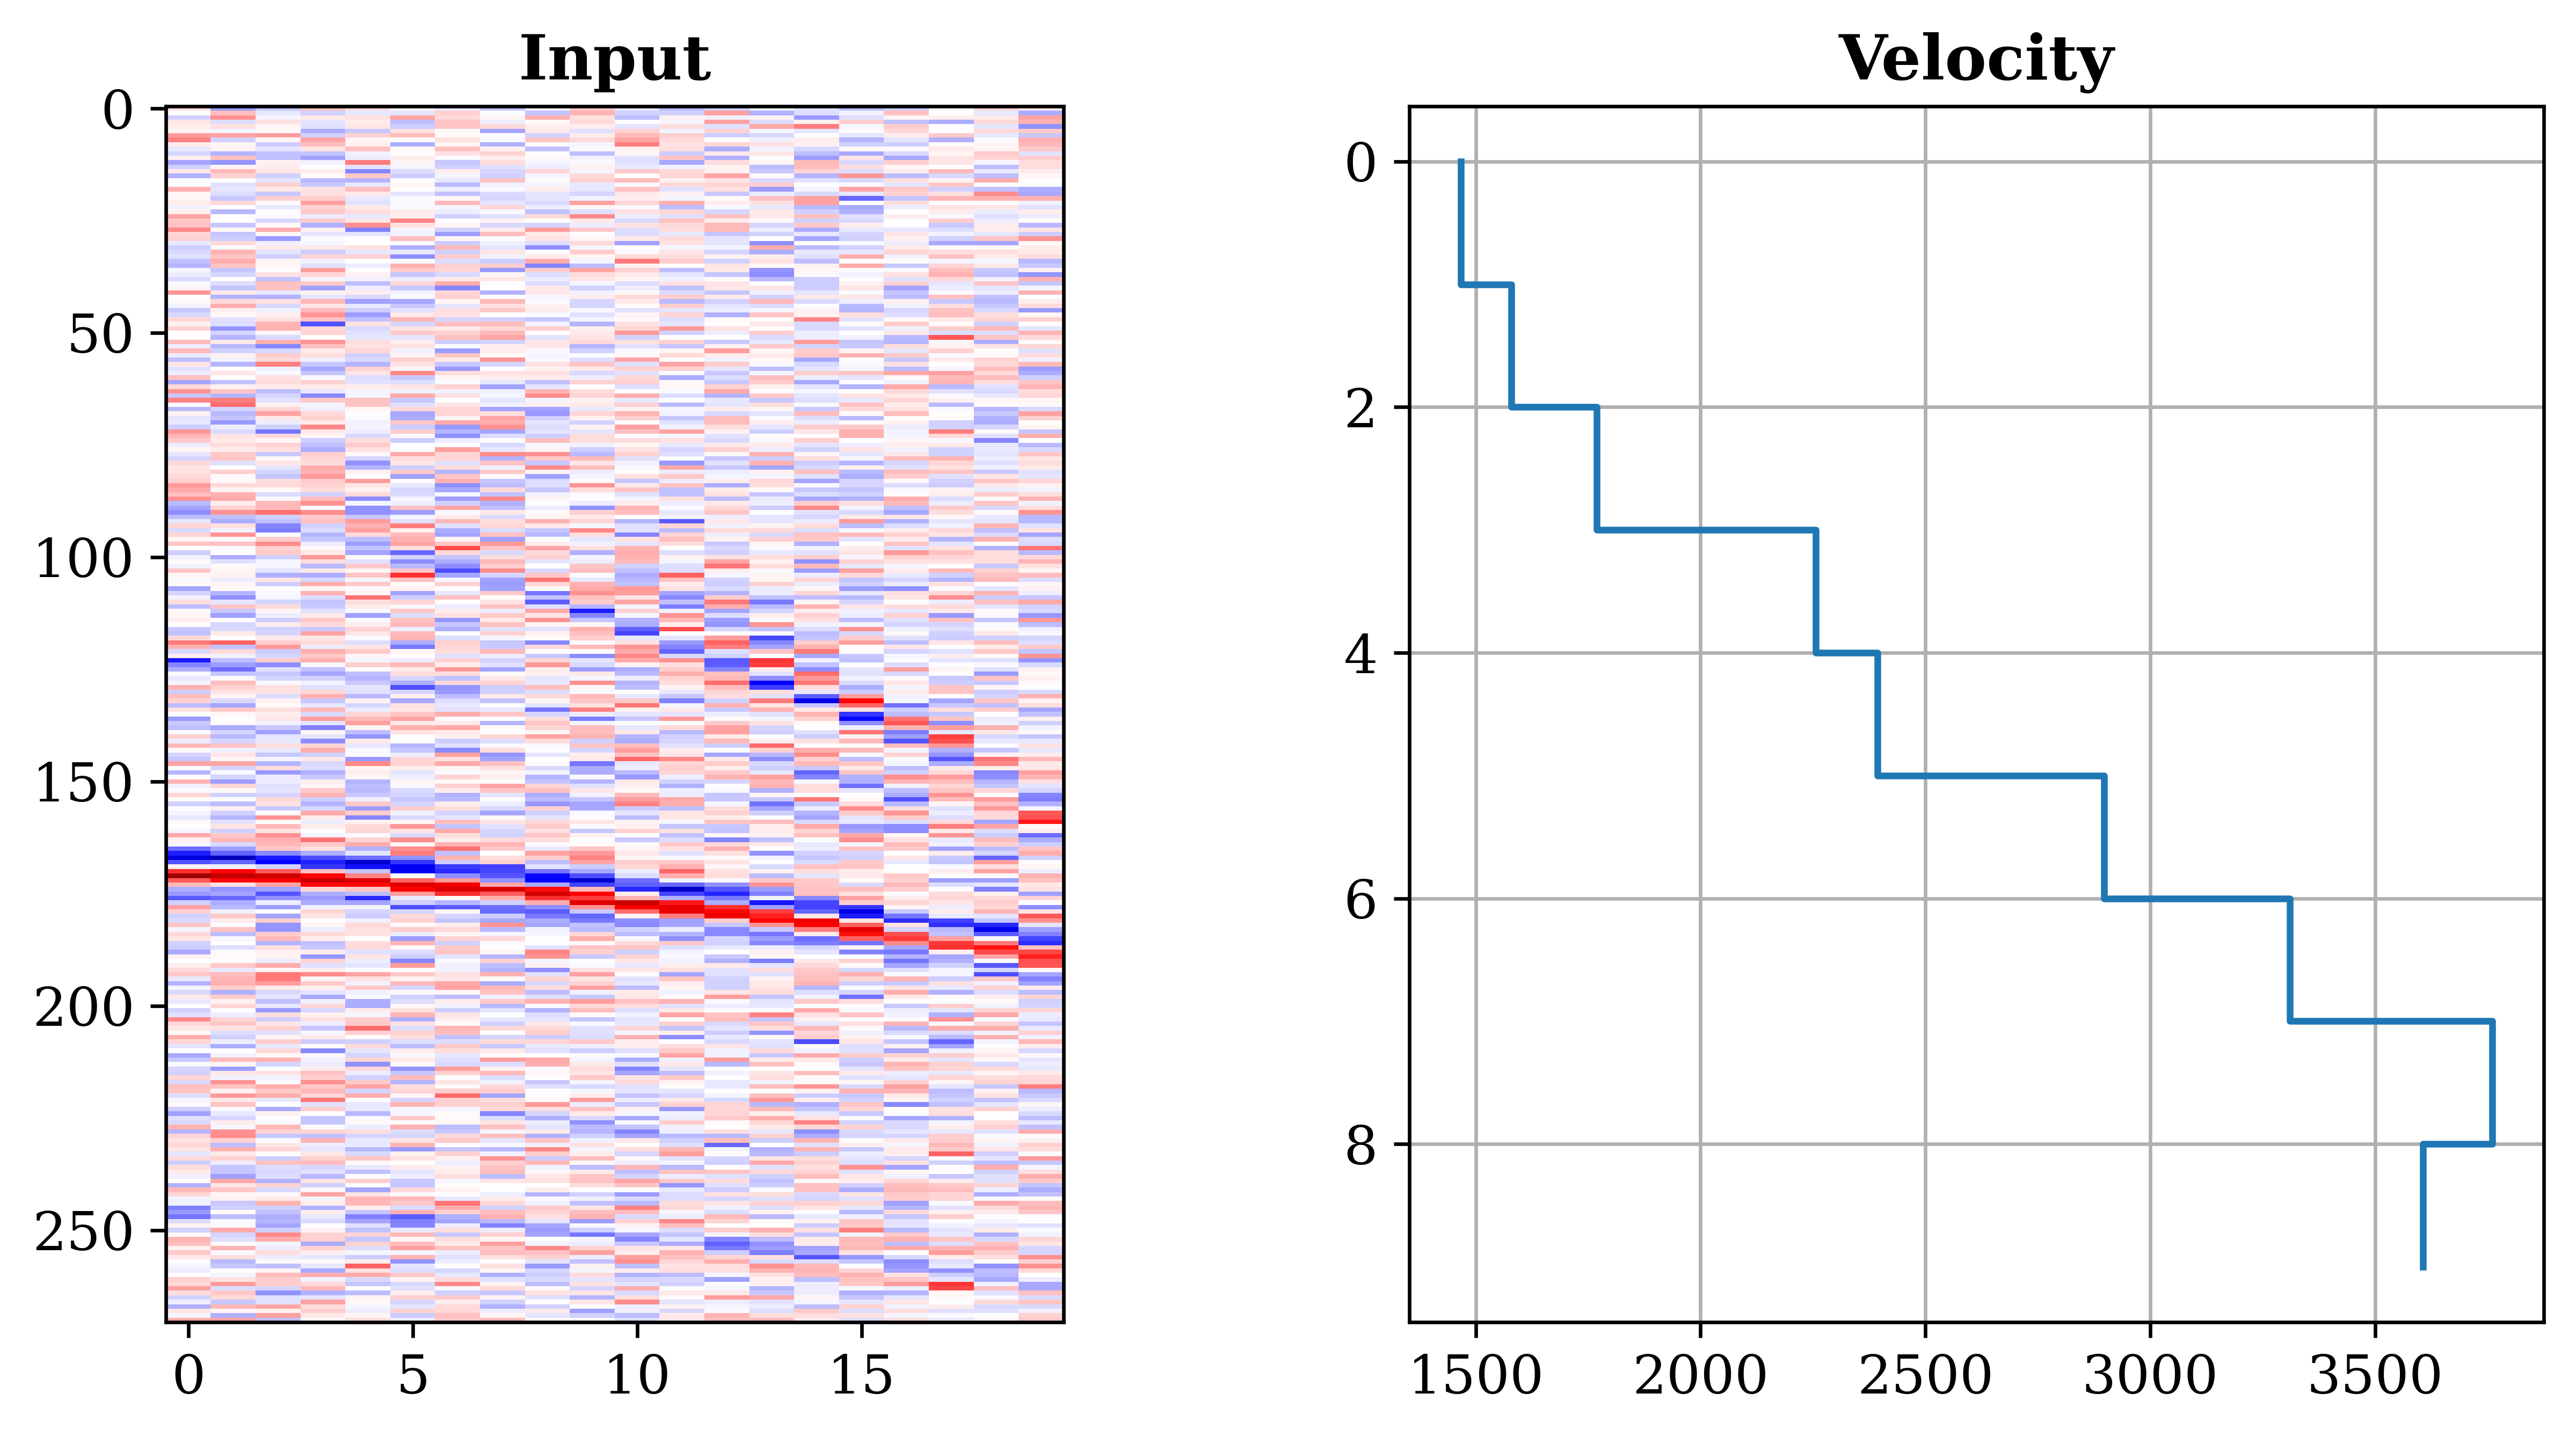

In [4]:
batch_size = config.batch_size

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

for i, X in enumerate(train_dataloader):
    if i == 0:
        for j in range(4):
            f, ax = plt.subplots(1, 2, figsize=(10, 5))
            ax[0].imshow(X['inputs_embeds'][j, :, :].swapaxes(0, 1) - X['inputs_embeds'][j, :, :].mean(), 
                         aspect=.1, vmin=vmin_all, vmax=vmax_all, cmap='seismic')
            ax[0].set_title("Input")
            ax[1].step(np.pad(X['vel'][j, :], (0, 1), 'edge'), np.arange(X['vel'][j, :].shape[-1] + 1))
            ax[1].invert_yaxis()
            ax[1].set_title("Velocity")
            ax[1].grid()

## Setup StorSeismic velocity prediction model

In [5]:
if not os.path.exists(config.parent_dir):
    os.makedirs(config.parent_dir)

### Load pre-trained model

In [6]:
model = torch.load(os.path.join(config.model_path, "model.pt"))
print(model)

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Linear(in_features=271, out_features=256, bias=True)
      (position_embeddings): PositionalEncoding(
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): PreLNBertAttention(
            (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
            (self): BertSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): PreLNBertSelfOutput(
              (dense): Linear(in_feature

### Change the prediction head

In [7]:
model.cls = VelpredHead(config)
print(model)

BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Linear(in_features=271, out_features=256, bias=True)
      (position_embeddings): PositionalEncoding(
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): PreLNBertAttention(
            (LayerNorm): LayerNorm((256,), eps=1e-12, elementwise_affine=True)
            (self): BertSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): PreLNBertSelfOutput(
              (dense): Linear(in_feature

### Check number of trainable parameters

In [8]:
def count_parameters(model):
    table = pd.DataFrame(columns=['Name', 'Parameter'])
    total_params = 0
    i = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        total_params+=param
        table.loc[i] = [name] + [param]
        i += 1
    display(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
count_parameters(model)

,Name,Parameter
0,bert.embeddings.word_embeddings.weight,69376
1,bert.embeddings.word_embeddings.bias,256
2,bert.embeddings.LayerNorm.weight,256
3,bert.embeddings.LayerNorm.bias,256
4,bert.encoder.layer.0.attention.LayerNorm.weight,256
5,bert.encoder.layer.0.attention.LayerNorm.bias,256
6,bert.encoder.layer.0.attention.self.query.weight,65536
7,bert.encoder.layer.0.attention.self.query.bias,256
8,bert.encoder.layer.0.attention.self.key.weight,65536
9,bert.encoder.layer.0.attention.self.key.bias,256


Total Trainable Params: 3298831


3298831

#### Send model to device

In [9]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
print("Using device: {}".format(device))

Using device: cuda


## Training

### Set up training hyperparameters

In [10]:
# Optimizer
optim = RAdam(model.parameters(), lr=config.lr)

# Loss
loss_fn = nn.L1Loss()

# Number of epochs
epochs = config.epoch

### Train

<IPython.core.display.Javascript object>


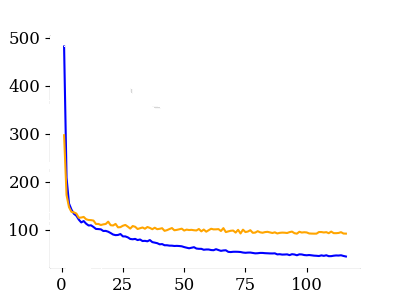

In [11]:
%matplotlib notebook

plt.ion()
f, ax = plt.subplots(figsize=(4, 3))

In [12]:
model, avg_train_loss, avg_valid_loss, time_per_epoch = \
run_velpred(model, optim, loss_fn, train_dataloader, test_dataloader, config.vel_size, epochs, device, 
            tmp_dir=config.parent_dir, patience=config.patience, plot=True, f=f, ax=ax)

%matplotlib inline
plt.ioff()

  0%|                                                    | 0/75 [00:00<?, ?it/s]/home/randycm/anaconda3/envs/transformers-3/lib/python3.8/site-packages/radam/radam.py:58: UserWarning: This overload of addcmul_ is deprecated:
	addcmul_(Number value, Tensor tensor1, Tensor tensor2)
Consider using one of the following signatures instead:
	addcmul_(Tensor tensor1, Tensor tensor2, *, Number value) (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448234945/work/torch/csrc/utils/python_arg_parser.cpp:1025.)
  exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
Validation 0: 100%|██████████████████| 19/19 [00:00<00:00, 137.77it/s, loss=322]


Epoch time: 2.75 s
Total time elapsed: 2.75 s
---------------------------------------
Validation loss decreased (inf --> 296.589860).  Saving model ...


Validation 1: 100%|██████████████████| 19/19 [00:00<00:00, 140.91it/s, loss=184]


Epoch time: 2.42 s
Total time elapsed: 5.24 s
---------------------------------------
Validation loss decreased (296.589860 --> 172.076749).  Saving model ...


Validation 2: 100%|██████████████████| 19/19 [00:00<00:00, 131.61it/s, loss=130]


Epoch time: 2.45 s
Total time elapsed: 7.78 s
---------------------------------------
Validation loss decreased (172.076749 --> 146.700975).  Saving model ...


Validation 3: 100%|██████████████████| 19/19 [00:00<00:00, 136.61it/s, loss=150]


Epoch time: 2.42 s
Total time elapsed: 10.28 s
---------------------------------------
Validation loss decreased (146.700975 --> 136.824539).  Saving model ...


Validation 4: 100%|██████████████████| 19/19 [00:00<00:00, 137.27it/s, loss=122]


Epoch time: 2.43 s
Total time elapsed: 12.79 s
---------------------------------------
Validation loss decreased (136.824539 --> 135.830293).  Saving model ...


Validation 5: 100%|██████████████████| 19/19 [00:00<00:00, 132.92it/s, loss=128]


Epoch time: 2.81 s
Total time elapsed: 15.69 s
---------------------------------------
Validation loss decreased (135.830293 --> 133.344645).  Saving model ...


Validation 6: 100%|██████████████████| 19/19 [00:00<00:00, 132.25it/s, loss=116]


Epoch time: 3.12 s
Total time elapsed: 18.89 s
---------------------------------------
Validation loss decreased (133.344645 --> 124.638952).  Saving model ...


Validation 7: 100%|██████████████████| 19/19 [00:00<00:00, 132.11it/s, loss=117]


Epoch time: 3.09 s
Total time elapsed: 22.05 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 8: 100%|██████████████████| 19/19 [00:00<00:00, 136.17it/s, loss=129]


Epoch time: 3.08 s
Total time elapsed: 25.18 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 9: 100%|██████████████████| 19/19 [00:00<00:00, 140.59it/s, loss=127]


Epoch time: 2.88 s
Total time elapsed: 28.10 s
---------------------------------------
Validation loss decreased (124.638952 --> 121.401085).  Saving model ...


Validation 10: 100%|█████████████████| 19/19 [00:00<00:00, 139.75it/s, loss=136]


Epoch time: 2.44 s
Total time elapsed: 30.61 s
---------------------------------------
Validation loss decreased (121.401085 --> 119.891441).  Saving model ...


Validation 11: 100%|█████████████████| 19/19 [00:00<00:00, 142.43it/s, loss=107]


Epoch time: 2.43 s
Total time elapsed: 33.12 s
---------------------------------------
Validation loss decreased (119.891441 --> 119.613517).  Saving model ...


Validation 12: 100%|█████████████████| 19/19 [00:00<00:00, 138.27it/s, loss=108]


Epoch time: 2.70 s
Total time elapsed: 35.89 s
---------------------------------------
Validation loss decreased (119.613517 --> 118.686057).  Saving model ...


Validation 13: 100%|█████████████████| 19/19 [00:00<00:00, 138.37it/s, loss=102]


Epoch time: 2.45 s
Total time elapsed: 38.41 s
---------------------------------------
Validation loss decreased (118.686057 --> 111.641922).  Saving model ...


Validation 14: 100%|█████████████████| 19/19 [00:00<00:00, 143.28it/s, loss=112]


Epoch time: 2.49 s
Total time elapsed: 40.98 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 15: 100%|█████████████████| 19/19 [00:00<00:00, 137.51it/s, loss=121]


Epoch time: 2.44 s
Total time elapsed: 43.47 s
---------------------------------------
Validation loss decreased (111.641922 --> 109.448734).  Saving model ...


Validation 16: 100%|█████████████████| 19/19 [00:00<00:00, 126.41it/s, loss=123]


Epoch time: 2.43 s
Total time elapsed: 45.97 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 17: 100%|█████████████████| 19/19 [00:00<00:00, 134.29it/s, loss=108]


Epoch time: 2.46 s
Total time elapsed: 48.49 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 18: 100%|█████████████████| 19/19 [00:00<00:00, 139.78it/s, loss=117]


Epoch time: 2.65 s
Total time elapsed: 51.18 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 19: 100%|█████████████████| 19/19 [00:00<00:00, 141.85it/s, loss=112]


Epoch time: 2.43 s
Total time elapsed: 53.66 s
---------------------------------------
Validation loss decreased (109.448734 --> 109.015740).  Saving model ...


Validation 20: 100%|█████████████████| 19/19 [00:00<00:00, 144.54it/s, loss=122]


Epoch time: 2.41 s
Total time elapsed: 56.14 s
---------------------------------------
Validation loss decreased (109.015740 --> 108.439280).  Saving model ...


Validation 21: 100%|█████████████████| 19/19 [00:00<00:00, 144.33it/s, loss=116]


Epoch time: 2.43 s
Total time elapsed: 58.64 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 22: 100%|█████████████████| 19/19 [00:00<00:00, 134.37it/s, loss=117]


Epoch time: 2.91 s
Total time elapsed: 61.60 s
---------------------------------------
Validation loss decreased (108.439280 --> 104.617483).  Saving model ...


Validation 23: 100%|█████████████████| 19/19 [00:00<00:00, 136.09it/s, loss=101]


Epoch time: 2.54 s
Total time elapsed: 64.21 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 24: 100%|█████████████████| 19/19 [00:00<00:00, 137.14it/s, loss=127]


Epoch time: 2.47 s
Total time elapsed: 66.73 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 25: 100%|████████████████| 19/19 [00:00<00:00, 148.14it/s, loss=99.4]


Epoch time: 2.54 s
Total time elapsed: 69.33 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 26: 100%|█████████████████| 19/19 [00:00<00:00, 142.08it/s, loss=102]


Epoch time: 2.43 s
Total time elapsed: 71.81 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 27: 100%|████████████████| 19/19 [00:00<00:00, 135.13it/s, loss=98.9]


Epoch time: 2.51 s
Total time elapsed: 74.36 s
---------------------------------------
Validation loss decreased (104.617483 --> 101.981943).  Saving model ...


Validation 28: 100%|█████████████████| 19/19 [00:00<00:00, 134.40it/s, loss=104]


Epoch time: 3.02 s
Total time elapsed: 77.46 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 29: 100%|█████████████████| 19/19 [00:00<00:00, 143.33it/s, loss=115]


Epoch time: 2.52 s
Total time elapsed: 80.03 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 30: 100%|█████████████████| 19/19 [00:00<00:00, 143.33it/s, loss=104]


Epoch time: 2.41 s
Total time elapsed: 82.50 s
---------------------------------------
Validation loss decreased (101.981943 --> 101.135656).  Saving model ...


Validation 31: 100%|██████████████████| 19/19 [00:00<00:00, 147.89it/s, loss=96]


Epoch time: 2.44 s
Total time elapsed: 85.02 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 32: 100%|█████████████████| 19/19 [00:00<00:00, 138.31it/s, loss=107]


Epoch time: 2.48 s
Total time elapsed: 87.55 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 33: 100%|█████████████████| 19/19 [00:00<00:00, 138.25it/s, loss=105]


Epoch time: 2.46 s
Total time elapsed: 90.05 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 34: 100%|████████████████| 19/19 [00:00<00:00, 141.05it/s, loss=98.7]


Epoch time: 2.45 s
Total time elapsed: 92.55 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 35: 100%|████████████████| 19/19 [00:00<00:00, 147.65it/s, loss=95.5]


Epoch time: 2.43 s
Total time elapsed: 95.03 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 36: 100%|████████████████| 19/19 [00:00<00:00, 139.92it/s, loss=95.4]


Epoch time: 2.58 s
Total time elapsed: 97.66 s
---------------------------------------
Validation loss decreased (101.135656 --> 100.748003).  Saving model ...


Validation 37: 100%|█████████████████| 19/19 [00:00<00:00, 138.29it/s, loss=103]


Epoch time: 2.46 s
Total time elapsed: 100.19 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 38: 100%|█████████████████| 19/19 [00:00<00:00, 138.96it/s, loss=116]


Epoch time: 2.43 s
Total time elapsed: 102.67 s
---------------------------------------
Validation loss decreased (100.748003 --> 100.723760).  Saving model ...


Validation 39: 100%|█████████████████| 19/19 [00:00<00:00, 135.14it/s, loss=113]


Epoch time: 2.63 s
Total time elapsed: 105.37 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 40: 100%|████████████████| 19/19 [00:00<00:00, 145.84it/s, loss=91.3]


Epoch time: 2.44 s
Total time elapsed: 107.86 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 41: 100%|█████████████████| 19/19 [00:00<00:00, 142.73it/s, loss=103]


Epoch time: 2.43 s
Total time elapsed: 110.33 s
---------------------------------------
Validation loss decreased (100.723760 --> 97.296647).  Saving model ...


Validation 42: 100%|██████████████████| 19/19 [00:00<00:00, 144.33it/s, loss=90]


Epoch time: 2.60 s
Total time elapsed: 113.01 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 43: 100%|██████████████████| 19/19 [00:00<00:00, 141.23it/s, loss=96]


Epoch time: 2.45 s
Total time elapsed: 115.51 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 44: 100%|█████████████████| 19/19 [00:00<00:00, 141.67it/s, loss=129]


Epoch time: 2.43 s
Total time elapsed: 117.98 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 45: 100%|█████████████████| 19/19 [00:00<00:00, 133.67it/s, loss=110]


Epoch time: 2.70 s
Total time elapsed: 120.74 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 46: 100%|█████████████████| 19/19 [00:00<00:00, 135.00it/s, loss=101]


Epoch time: 3.08 s
Total time elapsed: 123.87 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 47: 100%|█████████████████| 19/19 [00:00<00:00, 134.01it/s, loss=125]


Epoch time: 3.11 s
Total time elapsed: 127.03 s
---------------------------------------
EarlyStopping counter: 6 out of 20


Validation 48: 100%|█████████████████| 19/19 [00:00<00:00, 135.15it/s, loss=122]


Epoch time: 3.05 s
Total time elapsed: 130.13 s
---------------------------------------
EarlyStopping counter: 7 out of 20


Validation 49: 100%|████████████████| 19/19 [00:00<00:00, 134.22it/s, loss=95.1]


Epoch time: 3.00 s
Total time elapsed: 133.18 s
---------------------------------------
EarlyStopping counter: 8 out of 20


Validation 50: 100%|████████████████| 19/19 [00:00<00:00, 132.77it/s, loss=98.7]


Epoch time: 3.09 s
Total time elapsed: 136.32 s
---------------------------------------
EarlyStopping counter: 9 out of 20


Validation 51: 100%|████████████████| 19/19 [00:00<00:00, 120.56it/s, loss=97.2]


Epoch time: 2.63 s
Total time elapsed: 139.00 s
---------------------------------------
EarlyStopping counter: 10 out of 20


Validation 52: 100%|████████████████| 19/19 [00:00<00:00, 142.80it/s, loss=92.8]


Epoch time: 2.48 s
Total time elapsed: 141.52 s
---------------------------------------
EarlyStopping counter: 11 out of 20


Validation 53: 100%|██████████████████| 19/19 [00:00<00:00, 122.20it/s, loss=98]


Epoch time: 2.47 s
Total time elapsed: 144.05 s
---------------------------------------
EarlyStopping counter: 12 out of 20


Validation 54: 100%|████████████████| 19/19 [00:00<00:00, 137.41it/s, loss=94.7]


Epoch time: 2.46 s
Total time elapsed: 146.57 s
---------------------------------------
EarlyStopping counter: 13 out of 20


Validation 55: 100%|█████████████████| 19/19 [00:00<00:00, 144.42it/s, loss=103]


Epoch time: 2.43 s
Total time elapsed: 149.05 s
---------------------------------------
EarlyStopping counter: 14 out of 20


Validation 56: 100%|████████████████| 19/19 [00:00<00:00, 145.98it/s, loss=94.1]


Epoch time: 2.41 s
Total time elapsed: 151.51 s
---------------------------------------
Validation loss decreased (97.296647 --> 96.264425).  Saving model ...


Validation 57: 100%|█████████████████| 19/19 [00:00<00:00, 149.30it/s, loss=102]


Epoch time: 2.40 s
Total time elapsed: 153.98 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 58: 100%|████████████████| 19/19 [00:00<00:00, 139.11it/s, loss=91.7]


Epoch time: 2.47 s
Total time elapsed: 156.50 s
---------------------------------------
Validation loss decreased (96.264425 --> 95.510564).  Saving model ...


Validation 59: 100%|████████████████| 19/19 [00:00<00:00, 133.18it/s, loss=98.9]


Epoch time: 2.71 s
Total time elapsed: 159.28 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 60: 100%|████████████████| 19/19 [00:00<00:00, 133.74it/s, loss=95.7]


Epoch time: 3.07 s
Total time elapsed: 162.40 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 61: 100%|████████████████| 19/19 [00:00<00:00, 130.64it/s, loss=87.7]


Epoch time: 3.07 s
Total time elapsed: 165.51 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 62: 100%|████████████████| 19/19 [00:00<00:00, 134.32it/s, loss=98.1]


Epoch time: 3.07 s
Total time elapsed: 168.64 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 63: 100%|████████████████| 19/19 [00:00<00:00, 135.21it/s, loss=87.4]


Epoch time: 3.09 s
Total time elapsed: 171.86 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 64: 100%|████████████████| 19/19 [00:00<00:00, 133.12it/s, loss=79.6]


Epoch time: 3.06 s
Total time elapsed: 174.97 s
---------------------------------------
EarlyStopping counter: 6 out of 20


Validation 65: 100%|█████████████████| 19/19 [00:00<00:00, 135.45it/s, loss=100]


Epoch time: 3.04 s
Total time elapsed: 178.06 s
---------------------------------------
EarlyStopping counter: 7 out of 20


Validation 66: 100%|████████████████| 19/19 [00:00<00:00, 131.34it/s, loss=90.6]


Epoch time: 3.05 s
Total time elapsed: 181.15 s
---------------------------------------
Validation loss decreased (95.510564 --> 94.703077).  Saving model ...


Validation 67: 100%|█████████████████| 19/19 [00:00<00:00, 133.36it/s, loss=103]


Epoch time: 3.12 s
Total time elapsed: 184.34 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 68: 100%|█████████████████| 19/19 [00:00<00:00, 134.55it/s, loss=103]


Epoch time: 3.07 s
Total time elapsed: 187.46 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 69: 100%|████████████████| 19/19 [00:00<00:00, 141.75it/s, loss=87.7]


Epoch time: 2.57 s
Total time elapsed: 190.08 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 70: 100%|████████████████| 19/19 [00:00<00:00, 124.10it/s, loss=93.3]


Epoch time: 2.44 s
Total time elapsed: 192.57 s
---------------------------------------
Validation loss decreased (94.703077 --> 93.664351).  Saving model ...


Validation 71: 100%|████████████████| 19/19 [00:00<00:00, 118.35it/s, loss=87.3]


Epoch time: 2.53 s
Total time elapsed: 195.17 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 72: 100%|████████████████| 19/19 [00:00<00:00, 137.55it/s, loss=95.7]


Epoch time: 2.47 s
Total time elapsed: 197.70 s
---------------------------------------
Validation loss decreased (93.664351 --> 91.837710).  Saving model ...


Validation 73: 100%|█████████████████| 19/19 [00:00<00:00, 139.81it/s, loss=113]


Epoch time: 2.46 s
Total time elapsed: 200.23 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 74: 100%|█████████████████| 19/19 [00:00<00:00, 143.58it/s, loss=104]


Epoch time: 2.48 s
Total time elapsed: 202.76 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 75: 100%|█████████████████| 19/19 [00:00<00:00, 141.99it/s, loss=105]


Epoch time: 2.42 s
Total time elapsed: 205.23 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 76: 100%|█████████████████| 19/19 [00:00<00:00, 137.56it/s, loss=110]


Epoch time: 2.43 s
Total time elapsed: 207.71 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 77: 100%|█████████████████| 19/19 [00:00<00:00, 143.29it/s, loss=101]


Epoch time: 2.46 s
Total time elapsed: 210.22 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 78: 100%|█████████████████| 19/19 [00:00<00:00, 139.83it/s, loss=105]


Epoch time: 2.42 s
Total time elapsed: 212.69 s
---------------------------------------
EarlyStopping counter: 6 out of 20


Validation 79: 100%|████████████████| 19/19 [00:00<00:00, 141.97it/s, loss=99.5]


Epoch time: 2.57 s
Total time elapsed: 215.31 s
---------------------------------------
EarlyStopping counter: 7 out of 20


Validation 80: 100%|█████████████████| 19/19 [00:00<00:00, 138.95it/s, loss=108]


Epoch time: 2.43 s
Total time elapsed: 217.79 s
---------------------------------------
EarlyStopping counter: 8 out of 20


Validation 81: 100%|█████████████████| 19/19 [00:00<00:00, 142.36it/s, loss=100]


Epoch time: 2.41 s
Total time elapsed: 220.27 s
---------------------------------------
EarlyStopping counter: 9 out of 20


Validation 82: 100%|█████████████████| 19/19 [00:00<00:00, 143.72it/s, loss=106]


Epoch time: 2.43 s
Total time elapsed: 222.75 s
---------------------------------------
EarlyStopping counter: 10 out of 20


Validation 83: 100%|████████████████| 19/19 [00:00<00:00, 139.07it/s, loss=87.9]


Epoch time: 2.44 s
Total time elapsed: 225.24 s
---------------------------------------
EarlyStopping counter: 11 out of 20


Validation 84: 100%|█████████████████| 19/19 [00:00<00:00, 140.82it/s, loss=103]


Epoch time: 2.43 s
Total time elapsed: 227.73 s
---------------------------------------
EarlyStopping counter: 12 out of 20


Validation 85: 100%|█████████████████| 19/19 [00:00<00:00, 139.56it/s, loss=107]


Epoch time: 2.47 s
Total time elapsed: 230.25 s
---------------------------------------
EarlyStopping counter: 13 out of 20


Validation 86: 100%|████████████████| 19/19 [00:00<00:00, 138.61it/s, loss=99.1]


Epoch time: 2.45 s
Total time elapsed: 232.75 s
---------------------------------------
EarlyStopping counter: 14 out of 20


Validation 87: 100%|████████████████| 19/19 [00:00<00:00, 136.72it/s, loss=80.5]


Epoch time: 2.41 s
Total time elapsed: 235.21 s
---------------------------------------
Validation loss decreased (91.837710 --> 91.834506).  Saving model ...


Validation 88: 100%|████████████████| 19/19 [00:00<00:00, 141.97it/s, loss=85.3]


Epoch time: 2.43 s
Total time elapsed: 237.71 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 89: 100%|████████████████| 19/19 [00:00<00:00, 136.01it/s, loss=88.2]


Epoch time: 2.43 s
Total time elapsed: 240.18 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 90: 100%|████████████████| 19/19 [00:00<00:00, 138.45it/s, loss=95.4]


Epoch time: 2.42 s
Total time elapsed: 242.65 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 91: 100%|████████████████| 19/19 [00:00<00:00, 144.12it/s, loss=94.4]


Epoch time: 2.46 s
Total time elapsed: 245.16 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 92: 100%|████████████████| 19/19 [00:00<00:00, 144.01it/s, loss=96.3]


Epoch time: 2.42 s
Total time elapsed: 247.62 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 93: 100%|████████████████| 19/19 [00:00<00:00, 143.98it/s, loss=87.7]


Epoch time: 2.42 s
Total time elapsed: 250.09 s
---------------------------------------
EarlyStopping counter: 6 out of 20


Validation 94: 100%|████████████████| 19/19 [00:00<00:00, 136.47it/s, loss=99.8]


Epoch time: 2.43 s
Total time elapsed: 252.58 s
---------------------------------------
EarlyStopping counter: 7 out of 20


Validation 95: 100%|████████████████| 19/19 [00:00<00:00, 135.45it/s, loss=94.6]


Epoch time: 2.76 s
Total time elapsed: 255.38 s
---------------------------------------
Validation loss decreased (91.834506 --> 91.420105).  Saving model ...


Validation 96: 100%|█████████████████| 19/19 [00:00<00:00, 132.43it/s, loss=116]


Epoch time: 3.05 s
Total time elapsed: 258.50 s
---------------------------------------
EarlyStopping counter: 1 out of 20


Validation 97: 100%|█████████████████| 19/19 [00:00<00:00, 133.56it/s, loss=111]


Epoch time: 3.08 s
Total time elapsed: 261.63 s
---------------------------------------
EarlyStopping counter: 2 out of 20


Validation 98: 100%|████████████████| 19/19 [00:00<00:00, 137.67it/s, loss=93.4]


Epoch time: 3.08 s
Total time elapsed: 264.76 s
---------------------------------------
EarlyStopping counter: 3 out of 20


Validation 99: 100%|████████████████| 19/19 [00:00<00:00, 137.61it/s, loss=84.6]


Epoch time: 3.05 s
Total time elapsed: 267.86 s
---------------------------------------
EarlyStopping counter: 4 out of 20


Validation 100: 100%|███████████████| 19/19 [00:00<00:00, 142.24it/s, loss=95.2]


Epoch time: 3.09 s
Total time elapsed: 271.00 s
---------------------------------------
EarlyStopping counter: 5 out of 20


Validation 101: 100%|███████████████| 19/19 [00:00<00:00, 139.89it/s, loss=80.1]


Epoch time: 2.61 s
Total time elapsed: 273.66 s
---------------------------------------
EarlyStopping counter: 6 out of 20


Validation 102: 100%|████████████████| 19/19 [00:00<00:00, 149.72it/s, loss=111]


Epoch time: 2.41 s
Total time elapsed: 276.12 s
---------------------------------------
EarlyStopping counter: 7 out of 20


Validation 103: 100%|███████████████| 19/19 [00:00<00:00, 141.41it/s, loss=94.6]


Epoch time: 2.47 s
Total time elapsed: 278.65 s
---------------------------------------
EarlyStopping counter: 8 out of 20


Validation 104: 100%|████████████████| 19/19 [00:00<00:00, 137.30it/s, loss=100]


Epoch time: 2.42 s
Total time elapsed: 281.13 s
---------------------------------------
EarlyStopping counter: 9 out of 20


Validation 105: 100%|███████████████| 19/19 [00:00<00:00, 133.15it/s, loss=76.3]


Epoch time: 2.45 s
Total time elapsed: 283.63 s
---------------------------------------
EarlyStopping counter: 10 out of 20


Validation 106: 100%|███████████████| 19/19 [00:00<00:00, 135.07it/s, loss=93.5]


Epoch time: 2.47 s
Total time elapsed: 286.15 s
---------------------------------------
EarlyStopping counter: 11 out of 20


Validation 107: 100%|███████████████| 19/19 [00:00<00:00, 140.14it/s, loss=89.2]


Epoch time: 2.44 s
Total time elapsed: 288.64 s
---------------------------------------
EarlyStopping counter: 12 out of 20


Validation 108: 100%|████████████████| 19/19 [00:00<00:00, 132.21it/s, loss=100]


Epoch time: 2.79 s
Total time elapsed: 291.48 s
---------------------------------------
EarlyStopping counter: 13 out of 20


Validation 109: 100%|████████████████| 19/19 [00:00<00:00, 135.48it/s, loss=121]


Epoch time: 3.10 s
Total time elapsed: 294.63 s
---------------------------------------
EarlyStopping counter: 14 out of 20


Validation 110: 100%|███████████████| 19/19 [00:00<00:00, 131.74it/s, loss=78.6]


Epoch time: 3.13 s
Total time elapsed: 297.81 s
---------------------------------------
EarlyStopping counter: 15 out of 20


Validation 111: 100%|███████████████| 19/19 [00:00<00:00, 134.83it/s, loss=92.2]


Epoch time: 3.11 s
Total time elapsed: 300.98 s
---------------------------------------
EarlyStopping counter: 16 out of 20


Validation 112: 100%|███████████████| 19/19 [00:00<00:00, 129.65it/s, loss=88.7]


Epoch time: 3.07 s
Total time elapsed: 304.10 s
---------------------------------------
EarlyStopping counter: 17 out of 20


Validation 113: 100%|███████████████| 19/19 [00:00<00:00, 134.33it/s, loss=97.2]


Epoch time: 3.06 s
Total time elapsed: 307.21 s
---------------------------------------
EarlyStopping counter: 18 out of 20


Validation 114: 100%|███████████████| 19/19 [00:00<00:00, 136.34it/s, loss=81.5]


Epoch time: 3.07 s
Total time elapsed: 310.33 s
---------------------------------------
EarlyStopping counter: 19 out of 20


Validation 115: 100%|█████████████████| 19/19 [00:00<00:00, 115.17it/s, loss=87]


Epoch time: 3.07 s
Total time elapsed: 313.44 s
---------------------------------------
EarlyStopping counter: 20 out of 20
Early stopping


### Plot results

In [13]:
# Acquisition information

x0 = 0.14 # Near offset
dx = 0.09 # Offset increment
dt = 0.008 # Time step

tensor([ 73, 177,  55, 169])


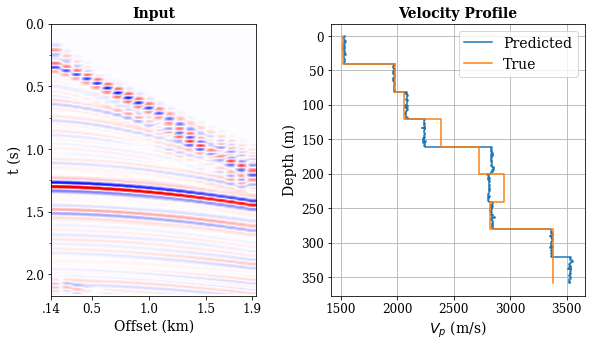

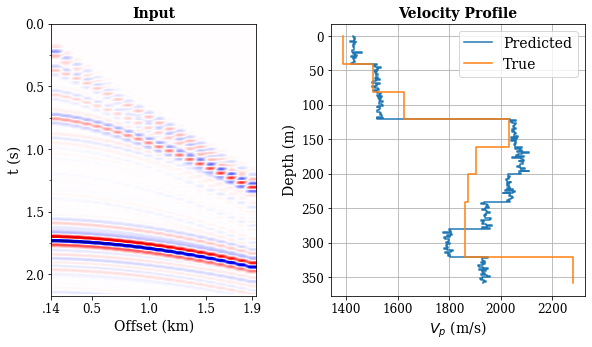

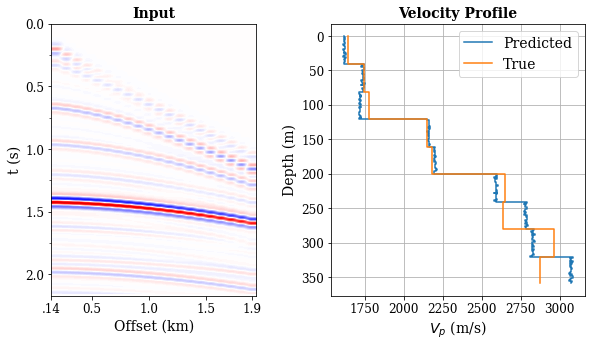

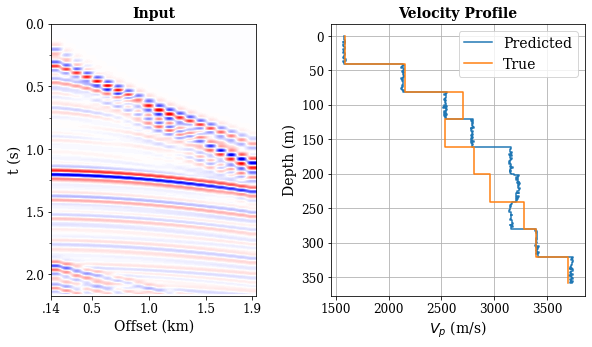

In [14]:
model.eval()

idx = torch.randint(len(test_data), (4,))
print(idx)

inputs_embeds = test_data.encodings['labels'][idx]
labels = F.interpolate(test_data.encodings['vel'][idx].unsqueeze(0).unsqueeze(0), 
                       size=(len(test_data.encodings['vel'][idx]), 271), 
                       mode='nearest')
labels = labels.squeeze()

with torch.no_grad():
    sample_output = model(inputs_embeds=inputs_embeds.to(device))

# sample_output.logits = torch.mean(sample_output.logits, 1)

for X, y, z in zip(inputs_embeds.cpu(), sample_output.logits.cpu(), labels):
    f, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(1 * (X - X.mean()).detach().swapaxes(0, 1) * 1, aspect=1.1, vmin=-1, vmax=1, cmap='seismic', 
                   extent=[x0, x0 + 20 * dx, 271 * dt, 0])
    ax[0].set_title("Input", fontsize=14)
    ax[0].set_xticks([x0, 0.5, 1, 1.5, 1.9])
    ax[0].set_xticklabels([".14", "0.5", "1.0", "1.5", "1.9"])
    ax[0].set_yticks(np.arange(0, 2.5, 0.5))
    ax[0].yaxis.set_minor_locator(AutoMinorLocator(2))
    ax[0].set_ylabel("t (s)")
    ax[0].set_xlabel("Offset (km)")
    ax[1].step(y, np.arange(0, 40*9, 40*9/(271)), label="Predicted")
    ax[1].step(z, np.arange(0, 40*9, 40*9/(271)), label="True")
    ax[1].invert_yaxis()
    ax[1].grid()
    ax[1].legend()
    ax[1].set_ylabel("Depth")
    ax[1].set_xlabel("$V_p$ (m/s)")
    ax[1].set_ylabel("Depth (m)")
    ax[1].set_title("Velocity Profile", fontsize=14)

## Finalize

In [15]:
# Save everything
print("Saving to", config.parent_dir)
if os.path.exists(os.path.join(config.parent_dir, 'model.pt')):
    if input("Path exists. Overwrite? (y/n)") == 'y':
        torch.save(model, os.path.join(config.parent_dir, 'model.pt'))
        avg_train_loss_arr = np.array(avg_train_loss)
        avg_valid_loss_arr = np.array(avg_valid_loss)
        np.save(os.path.join(config.parent_dir, 'train_loss.npy'), avg_train_loss_arr)
        np.save(os.path.join(config.parent_dir, 'valid_loss.npy'), avg_valid_loss_arr)
        torch.save(config, os.path.join(config.parent_dir, 'config.pt'))
        print("Saved successfully to", config.parent_dir)
    else:
        print("Saving failed.")
else:
    torch.save(model, os.path.join(config.parent_dir, 'model.pt'))
    avg_train_loss_arr = np.array(avg_train_loss)
    avg_valid_loss_arr = np.array(avg_valid_loss)
    np.save(os.path.join(config.parent_dir, 'train_loss.npy'), avg_train_loss_arr)
    np.save(os.path.join(config.parent_dir, 'valid_loss.npy'), avg_valid_loss_arr)
    torch.save(config, os.path.join(config.parent_dir, 'config.pt'))
    print("Saved successfully to", config.parent_dir)

Saving to ./results/finetune/velpred/
Path exists. Overwrite? (y/n)n
Saving failed.
